In [1]:
from prophet import Prophet
from prophet.plot import plot_plotly
import plotly.offline as py
py.init_notebook_mode()

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

In [3]:
from typing import Optional
from pathlib import Path

def find_project_root() -> Optional[Path]:
    current = Path(".").resolve()
    
    while True:
        if (current / ".git").exists():
            return current
        
        if current.parent == current:
            print("WARNING: No .git dir found")
            return current
              
        current = current.parent
        

PROJECT_ROOT = find_project_root()
PROJECT_ROOT

WindowsPath('C:/Users/Harsha/Documents/ISB_AMPBA/Term5/FP2/GroupAssignment/project')

In [4]:
# Tag this cell as 'parameters'
# BASE
COUNTRY = 'US'

interval = 0.95
EXPERIMENT = 'prophet forecasting'  # Name of experiment
RUN_NAME = COUNTRY  # Name of iteration (that will show
ARTIFACT_DIR = PROJECT_ROOT / 'artifact_dir'  # Dir for notebook outputs where plots are saved
model_dir  = "model\\prophet"
dataset_dir  = "datadir\\datasets"


In [5]:
# Parameters
COUNTRY = "RU"
EXPERIMENT = "prophet_forecasting"
intervel = 0.95


In [6]:
# Wrap all this is a parameter dict
run_params = {'experiment': EXPERIMENT,
              'iteration': RUN_NAME,
              'country': COUNTRY,
              'artifact_dir': ARTIFACT_DIR}

In [7]:
from mlflow.tracking import MlflowClient
import mlflow
experiment_name = "Prohpet Forecasting"
artifact_repository = './mlflow'

# Provide uri and connect to your tracking server
mlflow.set_tracking_uri('http://127.0.0.1:5000/')

# Initialize client
client = MlflowClient()

# If experiment doesn't exist then it will create new
# else it will take the experiment id and will use to to run the experiments
try:
    # Create experiment 
    experiment_id = client.create_experiment(experiment_name, artifact_location=artifact_repository)
except:
    # Get the experiment id if it already exists
    experiment_id = client.get_experiment_by_name(experiment_name).experiment_id

In [8]:
from typing import Dict, Any, Tuple
from typing import Optional
from pathlib import Path

import matplotlib.pyplot as plt
import mlflow
import numpy as np
from joblib import dump
from sklearn.metrics import recall_score, precision_score, roc_auc_score, roc_curve, precision_recall_curve, f1_score
import yaml
from logger import logger
import mlflow.sklearn
from mlflow.tracking import MlflowClient

def plot_line_graph(y_true: np.ndarray, y_pred: np.ndarray, model_name: str, plot_dir: str = None) -> str:
    """
    Plot the area under curve for the ROC curve.

    Args:
        y_true: Array of true y values
        y_pred: Array of predicted y values
        model_name: Name of model
        plot_dir: Directory to save plot in

    Returns:
        Output path of plot
    """
    
    # plot expected vs actual
    pyplot.plot(y_true, label='Actual')
    pyplot.plot(y_pred, label='Predicted')
    pyplot.legend()
    pyplot.show()
    Path(f"{plot_dir}\\plots").mkdir(parents=True, exist_ok=True)
    # Save figure
    if plot_dir:
        output_path = '{}\\plots\\line_graph_{}.png'.format(plot_dir, model_name)
        plt.savefig(output_path)
        logger.info('line graph saved to: {}'.format(output_path))
        return output_path


def plot_precision_recall(y_true: np.ndarray, y_pred: np.ndarray, model_name: str, plot_dir: str = None) -> str:
    """
    Plots the precision-recall curve.

    Args:
        y_true: Array of true y values
        y_pred: Array of predicted y values
        model_name: Name of model
        plot_dir: Directory to save plot in

    Returns:Ø
        Output path of plot
    """
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    plt.figure(figsize=(15, 5))
    plt.grid()
    plt.plot(thresholds, precision[1:], color='r', label='Precision')
    plt.plot(thresholds, recall[1:], color='b', label='Recall')
    plt.gca().invert_xaxis()
    plt.legend()
    plt.title('Precision-recall curve: {}'.format(model_name))
    Path(f"{plot_dir}\\plots").mkdir(parents=True, exist_ok=True)
    # Save figure
    if plot_dir:
        output_path = '{}/plots/precision_recall_{}.png'.format(plot_dir, model_name)
        
        plt.savefig(output_path)
        logger.info('Precision-recall curve saved to: {}'.format(output_path))
        return output_path


def save_model(model: Any, model_name: str, model_dir: str) -> str:
    """
    Saves model in pickle format

    Args:
        model: Model binary
        model_name: Name of model
        model_dir: Directory to save model in

    Returns:
        Output path of model
    """
    Path(f"{model_dir}/models").mkdir(parents=True, exist_ok=True)
    output_path = '{}/models/{}.pickle'.format(model_dir, model_name)
    logger.info('Model saved to: {}'.format(output_path))
    dump(model, output_path)

    return output_path


def evaluate_binary(y_true: np.ndarray, y_pred: np.ndarray, threshold: float = 0.5) -> \
        Tuple[float, float, float, float]:
    """
    Returns binary evaluation metrics

    Args:
        y_true: Array of true y values
        y_pred: Array of predicted y values
        threshold: Threshold to convert probabilies to binary values (default=0.5)

    Returns:
        Metrics for mase, RMSE, MAPE
    """
    
    mae = mean_absolute_error(y_true, y_pred)
    print('MAE: %.3f' % mae)
    mse = mean_squared_error(y_true, y_pred)
    print('MSE: %f' % mse)
    rmse = sqrt(mse)
    print('RMSE: %f' % rmse)


    logger.info('MAE: {:.3f} | MSE: {:.3f} | RMSE: {:.3f}'.format(mae, mse, rmse))
    return mae, mse, rmse


def save_metrics(mae, mse, rmse, metrics_dir: str, metrics_name:str)-> None:
    # Calculate metrics
    metrics = {}

    metrics["mae"] = float(mae)
    metrics["mse"] = float(mse)
    metrics["rmse"] = float(rmse)
    Path(f"{metrics_dir}/metrics").mkdir(parents=True, exist_ok=True)
    output_path = f"{metrics_dir}\\metrics\\{metrics_name}_mertics.yaml"
    logger.info('Model metrics to: {}'.format(output_path))
    with open(output_path, 'w+') as file:
        yaml.dump(metrics, file, default_flow_style=False)
        
def log_mlflow(experiment_id,run_params: Dict, model: Any, model_name: str, y_true: np.ndarray, y_pred: np.ndarray) -> None:
    """
    Logs result of model training and validation to mlflow

    Args:
        run_params: Dictionary containing parameters of run.
                    Expects keys for 'experiment', 'artifact_dir', 'iteration', and 'index.
        model: Model binary
        model_name: Name of model
        y_true: Array of true y values
        y_pred: Array of predicted y values

    Returns:
        None
    """
    
#     mlflow.set_tracking_uri("http://127.0.0.1:5000")
#     mlflow.set_experiment()
 
    mae, mse, rmse = evaluate_binary(y_true, y_pred)
    
    save_metrics(mae, mse, rmse ,metrics_dir= run_params['artifact_dir'],metrics_name =model_name+ "_" +run_params["country"])

    line_graph_path = plot_line_graph(y_true, y_pred, '{}'.format(model_name), run_params['artifact_dir'])
#     pr_path = plot_precision_recall(y_true, y_pred,
#                                     '{} prec= {:.2f} recall= {:.2f}'.format(model_name, precision, recall),
#                                     run_params['artifact_dir'])
    model_path = save_model(model, model_name, run_params['artifact_dir'])
    print(model_path)
    
    with mlflow.start_run(experiment_id=experiment_id,run_name=run_params['iteration']):
#         mlflow.sklearn.autolog() 
        mlflow.log_param('country', run_params['country'])
        mlflow.log_param('model', model_name)
        mlflow.log_metric('mae', mae)
        mlflow.log_metric('mse', mse)
        mlflow.log_metric('rmse', rmse)
        mlflow.log_artifact(model_path)
        mlflow.log_artifact(line_graph_path)
        mlflow.sklearn.log_model(model, model_name,
                                registered_model_name=model_name)
        
        # Instantiate the Path class
#         obj = Path(model_path)
#         obj.unlink(missing_ok=True)
#         mlflow.sklearn.save_model(model, model_path,
#                           serialization_format=mlflow.sklearn.SERIALIZATION_FORMAT_PICKLE)
        
        # Logging model to MLFlow
#         mlflow.sklearn.log_model(sk_model = model,
#                              artifact_path = model_path,
#                              registered_model_name = 'model_name')


In [9]:
df = pd.read_parquet(f"{PROJECT_ROOT}\\{dataset_dir}\\{COUNTRY}.parquet")
df.head()

Date  production
0 2002-01-01        7001
1 2002-02-01        7094
2 2002-03-01        7143
3 2002-04-01        7135
4 2002-05-01        7215

In [10]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        251 non-null    datetime64[ns]
 1   production  251 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 4.0 KB


In [11]:
df['Date'] = pd.DatetimeIndex(df['Date'])
df.dtypes

Date          datetime64[ns]
production             int64
dtype: object

In [12]:
df = df.rename(columns={'Date': 'ds',
                        'production': 'y'})

df.head()

ds     y
0 2002-01-01  7001
1 2002-02-01  7094
2 2002-03-01  7143
3 2002-04-01  7135
4 2002-05-01  7215

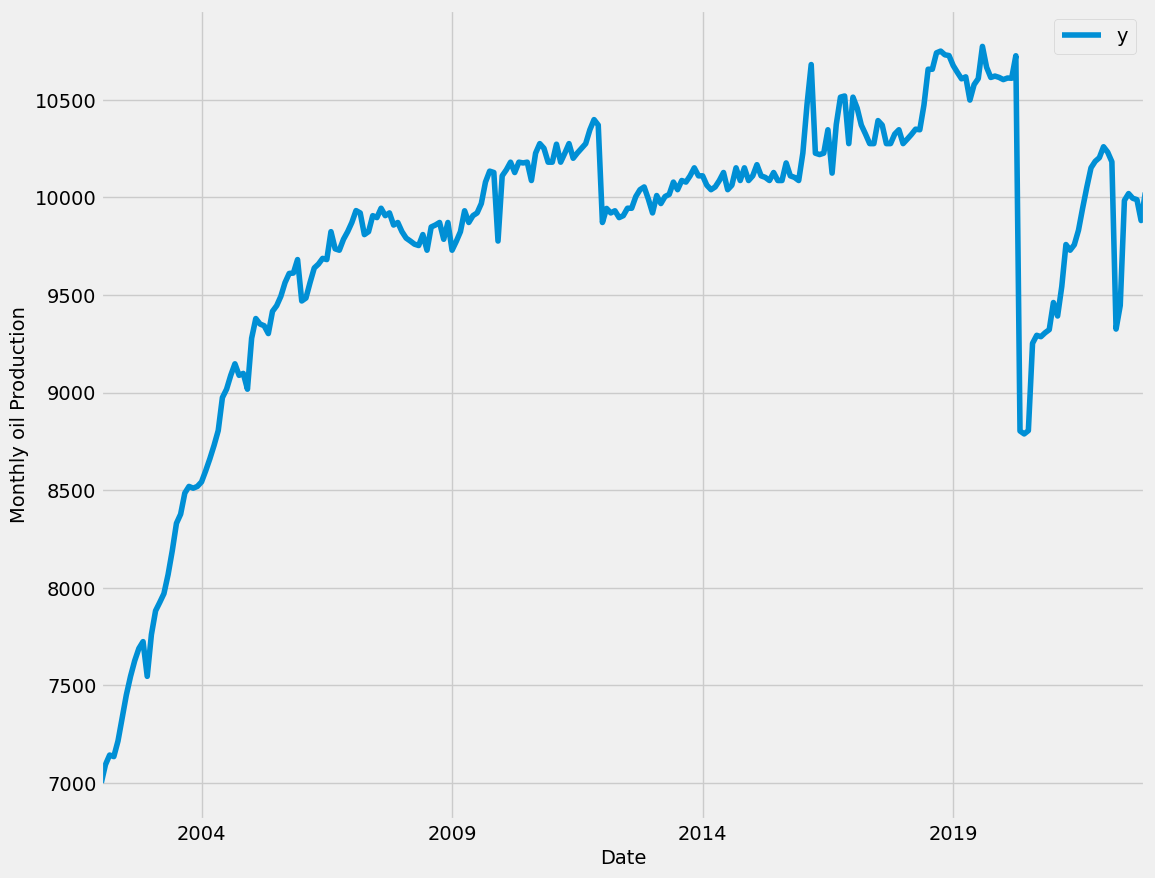

In [13]:
ax = df.set_index('ds').plot(figsize=(12, 10))
ax.set_ylabel('Monthly oil Production')
ax.set_xlabel('Date')

plt.show()

In [14]:
lockdowns = pd.DataFrame([
    {'holiday': 'lockdown_1', 'ds': '2020-03-21', 'lower_window': 0, 'ds_upper': '2020-06-06'},
    {'holiday': 'lockdown_2', 'ds': '2020-07-09', 'lower_window': 0, 'ds_upper': '2020-10-27'},
    {'holiday': 'lockdown_3', 'ds': '2021-02-13', 'lower_window': 0, 'ds_upper': '2021-02-17'},
    {'holiday': 'lockdown_4', 'ds': '2021-05-28', 'lower_window': 0, 'ds_upper': '2021-06-10'},
])
for t_col in ['ds', 'ds_upper']:
    lockdowns[t_col] = pd.to_datetime(lockdowns[t_col])
lockdowns['upper_window'] = (lockdowns['ds_upper'] - lockdowns['ds']).dt.days
lockdowns

holiday         ds  lower_window   ds_upper  upper_window
0  lockdown_1 2020-03-21             0 2020-06-06            77
1  lockdown_2 2020-07-09             0 2020-10-27           110
2  lockdown_3 2021-02-13             0 2021-02-17             4
3  lockdown_4 2021-05-28             0 2021-06-10            13

In [15]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
model1 = Prophet(interval_width=interval,holidays=lockdowns)
model2 = Prophet(interval_width=interval,holidays=lockdowns)

In [16]:
train = df.drop(df.index[-12:])
train.tail()

ds      y
234 2021-07-01   9831
235 2021-08-01   9945
236 2021-09-01  10052
237 2021-10-01  10151
238 2021-11-01  10184

In [17]:
model1.fit(train)
model2.fit(df)

[26/Feb/2023 07:34:07] INFO - Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


[26/Feb/2023 07:34:07] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


07:34:07 - cmdstanpy - INFO - Chain [1] start processing


[26/Feb/2023 07:34:07] INFO - Chain [1] start processing


07:34:07 - cmdstanpy - INFO - Chain [1] done processing


[26/Feb/2023 07:34:07] INFO - Chain [1] done processing


[26/Feb/2023 07:34:07] INFO - Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


[26/Feb/2023 07:34:07] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


07:34:07 - cmdstanpy - INFO - Chain [1] start processing


[26/Feb/2023 07:34:07] INFO - Chain [1] start processing


07:34:07 - cmdstanpy - INFO - Chain [1] done processing


[26/Feb/2023 07:34:07] INFO - Chain [1] done processing


In [18]:
# define the period for which we want a prediction
future = list()
for i in range(1, 13):
    date = '2022-%02d-01' % i
    future.append([date])
future = pd.DataFrame(future)
future.tail()

0
7   2022-08-01
8   2022-09-01
9   2022-10-01
10  2022-11-01
11  2022-12-01

MAE: 279.366
MSE: 93612.786204
RMSE: 305.962067
[26/Feb/2023 07:34:07] INFO - MAE: 279.366 | MSE: 93612.786 | RMSE: 305.962


[26/Feb/2023 07:34:07] INFO - Model metrics to: C:\Users\Harsha\Documents\ISB_AMPBA\Term5\FP2\GroupAssignment\project\artifact_dir\metrics\prophet_forecasting_RU_mertics.yaml


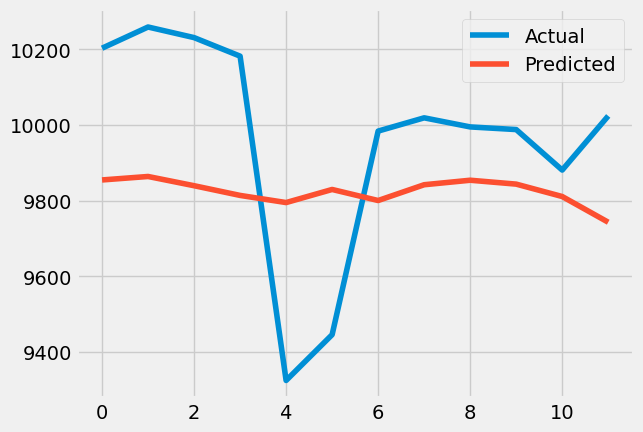

[26/Feb/2023 07:34:07] INFO - line graph saved to: C:\Users\Harsha\Documents\ISB_AMPBA\Term5\FP2\GroupAssignment\project\artifact_dir\plots\line_graph_prophet_forecasting.png


[26/Feb/2023 07:34:07] INFO - Model saved to: C:\Users\Harsha\Documents\ISB_AMPBA\Term5\FP2\GroupAssignment\project\artifact_dir/models/prophet_forecasting.pickle


C:\Users\Harsha\Documents\ISB_AMPBA\Term5\FP2\GroupAssignment\project\artifact_dir/models/prophet_forecasting.pickle


C:\Users\Harsha\anaconda3\envs\fp2\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning:

Setuptools is replacing distutils.

Registered model 'prophet_forecasting' already exists. Creating a new version of this model...
2023/02/26 07:34:11 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: prophet_forecasting, version 13


Created version '13' of model 'prophet_forecasting'.


<Figure size 640x480 with 0 Axes>

In [19]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
from matplotlib import pyplot
from math import sqrt
from pandas import to_datetime

future.columns = ['ds']
future['ds'] = to_datetime(future['ds'])
# use the model to make a forecast
forecast = model1.predict(future)
# calculate MAE between expected and predicted values for december
y_true = df['y'][-12:].values
y_pred = forecast['yhat'].values

# Logistic regression
model_name = 'prophet_forecasting'
log_mlflow(experiment_id,run_params, model1, model_name, y_true, y_pred)

In [20]:
future_dates = model2.make_future_dataframe(periods=12, freq='MS')
future_dates.tail()

ds
258 2023-07-01
259 2023-08-01
260 2023-09-01
261 2023-10-01
262 2023-11-01

In [21]:
forecast = model2.predict(future_dates)
forecast["y"] = df["y"]
forecast[['ds','y','yhat', 'yhat_lower', 'yhat_upper']].head()

ds       y         yhat   yhat_lower   yhat_upper
0 2002-01-01  7001.0  7125.304861  6775.198841  7491.210104
1 2002-02-01  7094.0  7203.215286  6843.492896  7577.992682
2 2002-03-01  7143.0  7248.438234  6882.054222  7638.360769
3 2002-04-01  7135.0  7246.839439  6881.762009  7606.400393
4 2002-05-01  7215.0  7304.215667  6927.740473  7668.301188

In [22]:
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'holidays', 'holidays_lower', 'holidays_upper', 'lockdown_1',
       'lockdown_1_lower', 'lockdown_1_upper', 'lockdown_2',
       'lockdown_2_lower', 'lockdown_2_upper', 'lockdown_3',
       'lockdown_3_lower', 'lockdown_3_upper', 'lockdown_4',
       'lockdown_4_lower', 'lockdown_4_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat', 'y'],
      dtype='object')

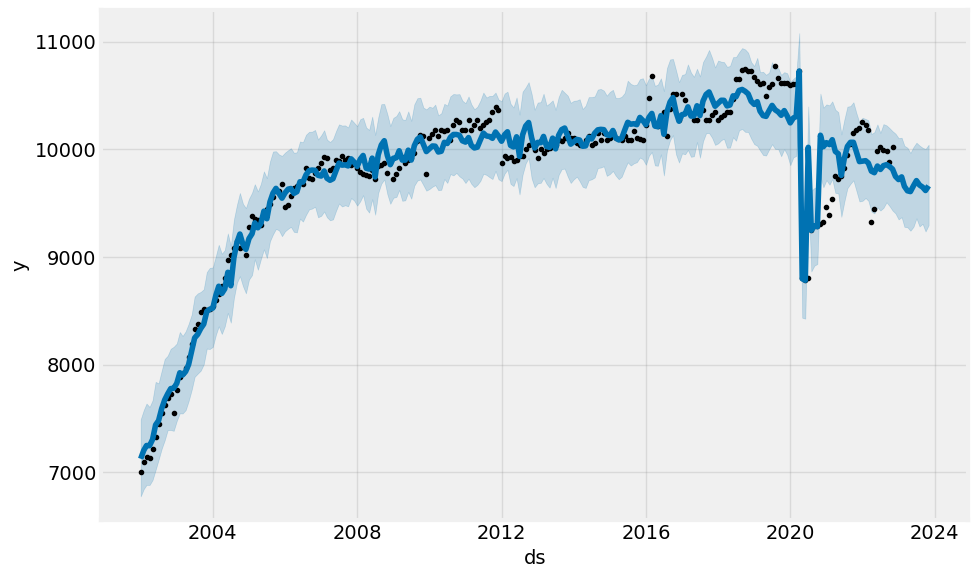

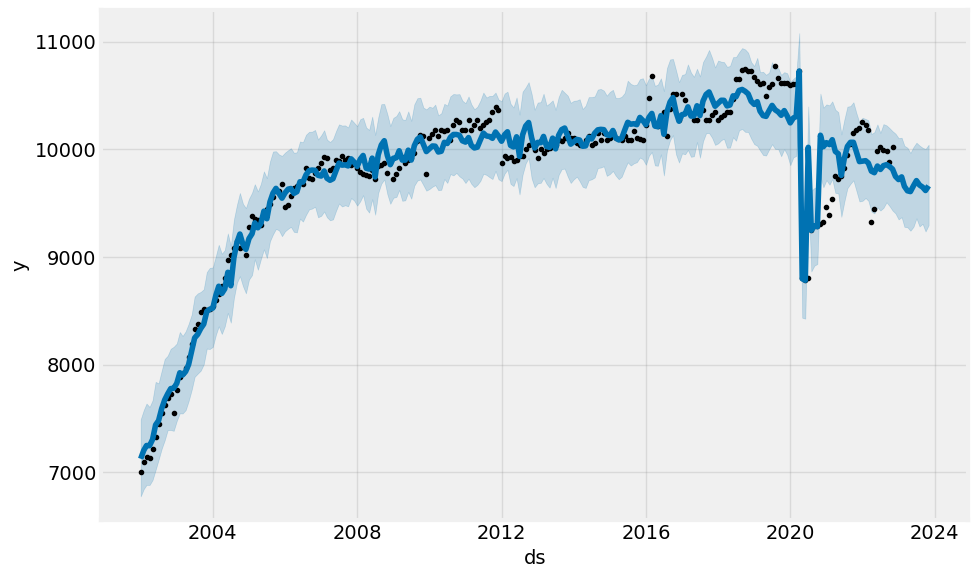

In [23]:
model2.plot(forecast, uncertainty=True)

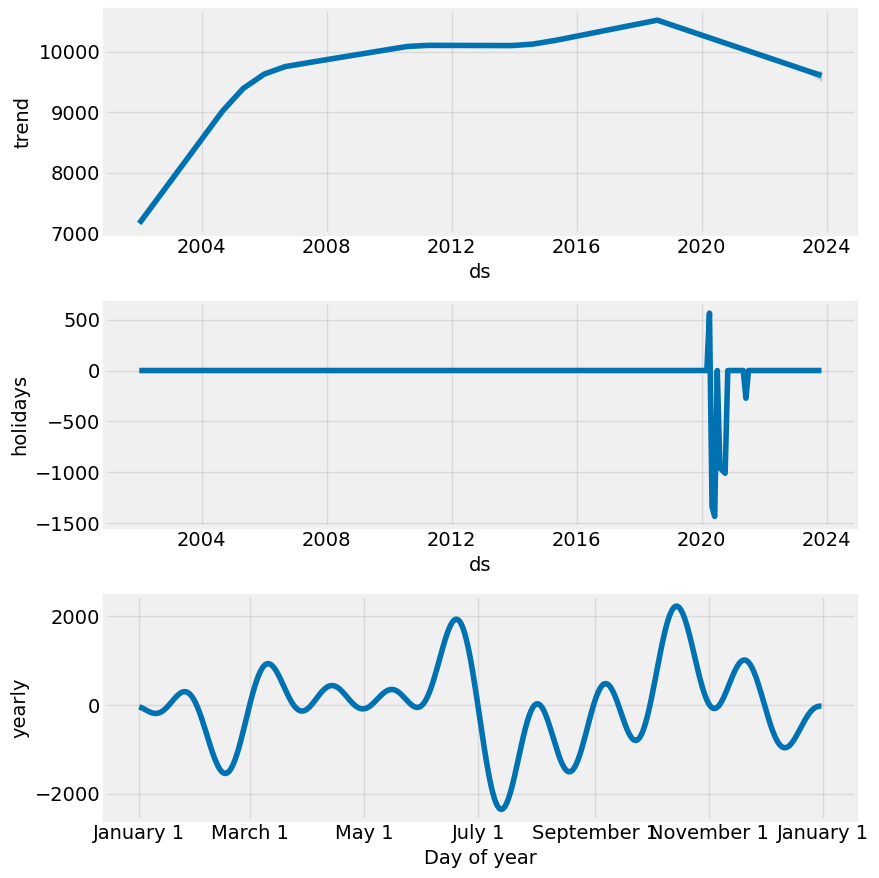

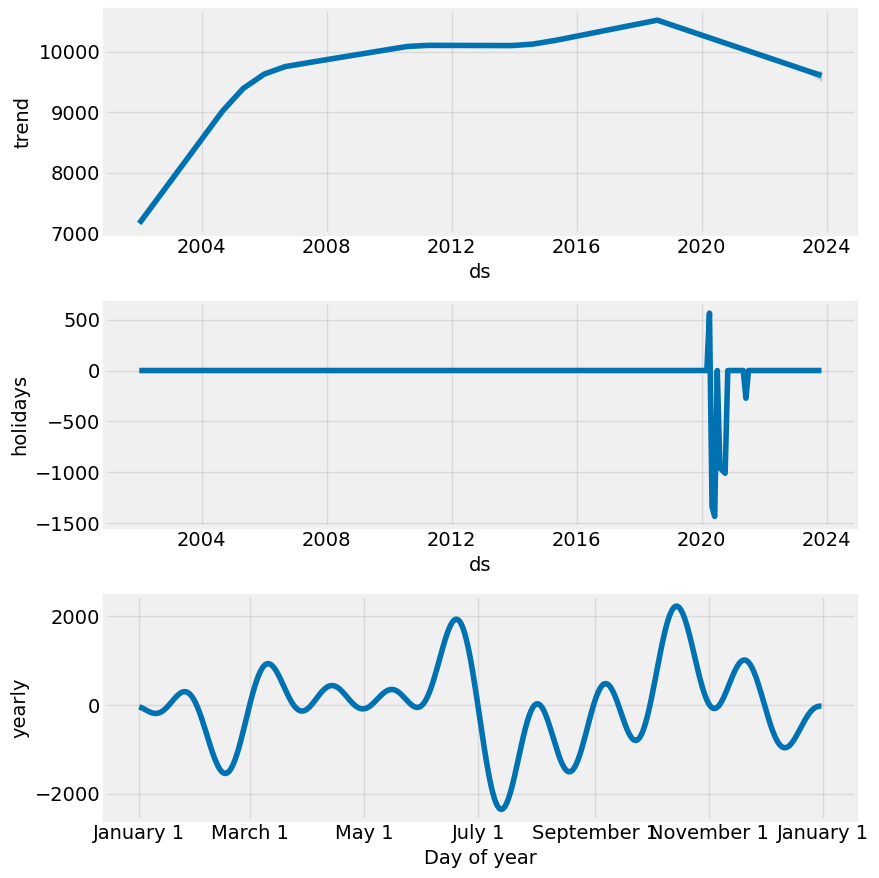

In [24]:
model2.plot_components(forecast)

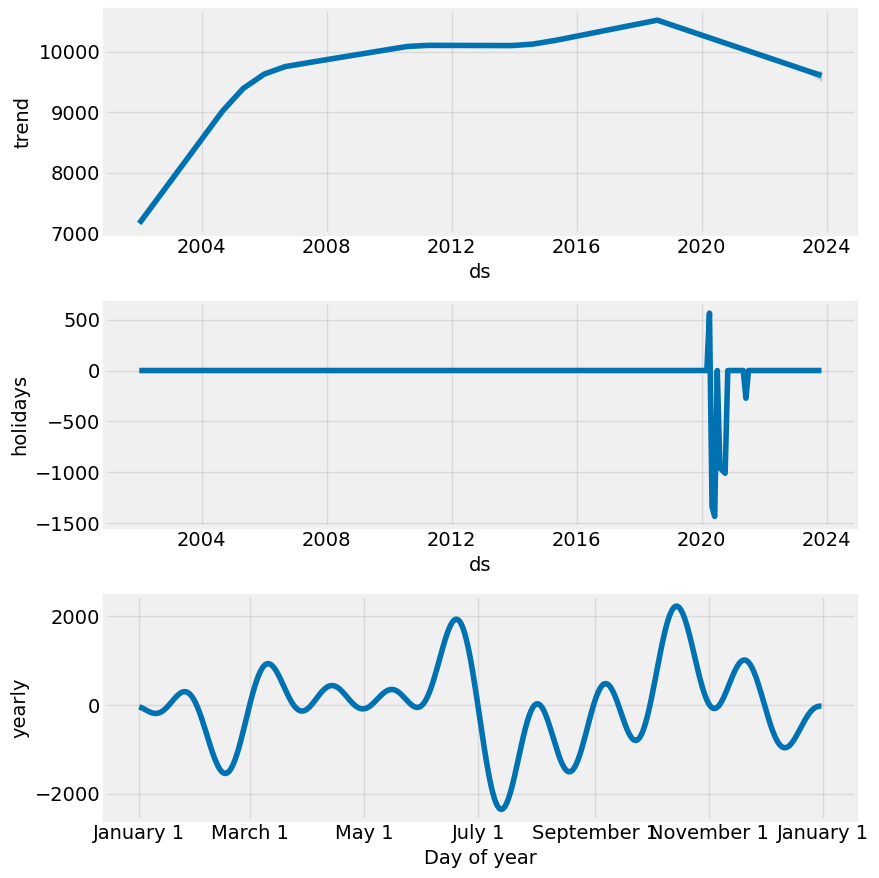

In [25]:
fig1 = model2.plot_components(forecast)

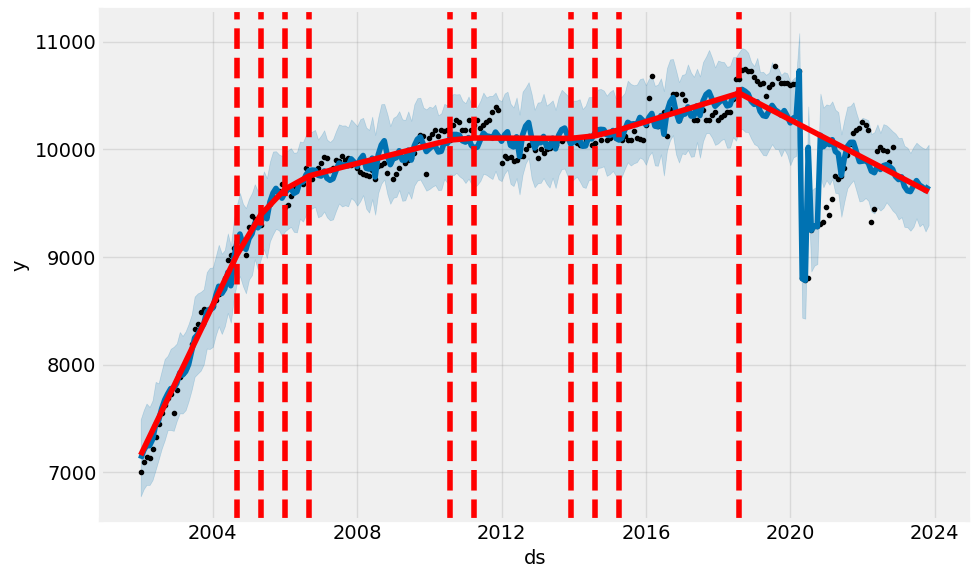

In [26]:
from prophet.plot import add_changepoints_to_plot
fig = model2.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model2, forecast)

In [27]:
model2.changepoints

8     2002-09-01
16    2003-05-01
24    2004-01-01
32    2004-09-01
40    2005-05-01
48    2006-01-01
56    2006-09-01
64    2007-05-01
72    2008-01-01
80    2008-09-01
88    2009-05-01
96    2010-01-01
103   2010-08-01
111   2011-04-01
119   2011-12-01
127   2012-08-01
135   2013-04-01
143   2013-12-01
151   2014-08-01
159   2015-04-01
167   2015-12-01
175   2016-08-01
183   2017-04-01
191   2017-12-01
199   2018-08-01
Name: ds, dtype: datetime64[ns]

[26/Feb/2023 07:34:15] INFO - Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


[26/Feb/2023 07:34:15] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


07:34:15 - cmdstanpy - INFO - Chain [1] start processing


[26/Feb/2023 07:34:15] INFO - Chain [1] start processing


07:34:15 - cmdstanpy - INFO - Chain [1] done processing


[26/Feb/2023 07:34:15] INFO - Chain [1] done processing


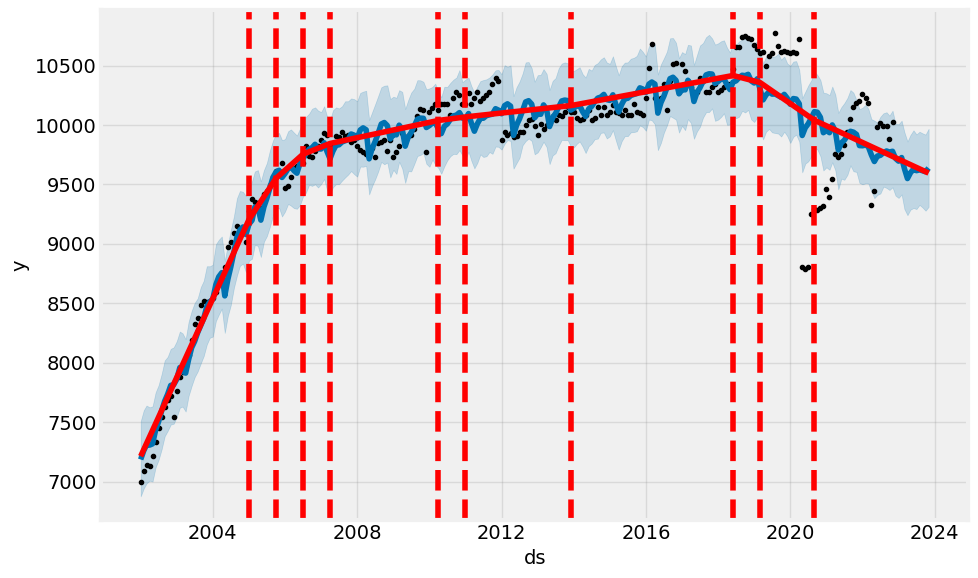

In [28]:
pro_change= Prophet(changepoint_range=0.9)
forecast = pro_change.fit(df).predict(future_dates)
fig= pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

[26/Feb/2023 07:34:15] INFO - Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


[26/Feb/2023 07:34:15] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


07:34:15 - cmdstanpy - INFO - Chain [1] start processing


[26/Feb/2023 07:34:15] INFO - Chain [1] start processing


07:34:15 - cmdstanpy - INFO - Chain [1] done processing


[26/Feb/2023 07:34:15] INFO - Chain [1] done processing


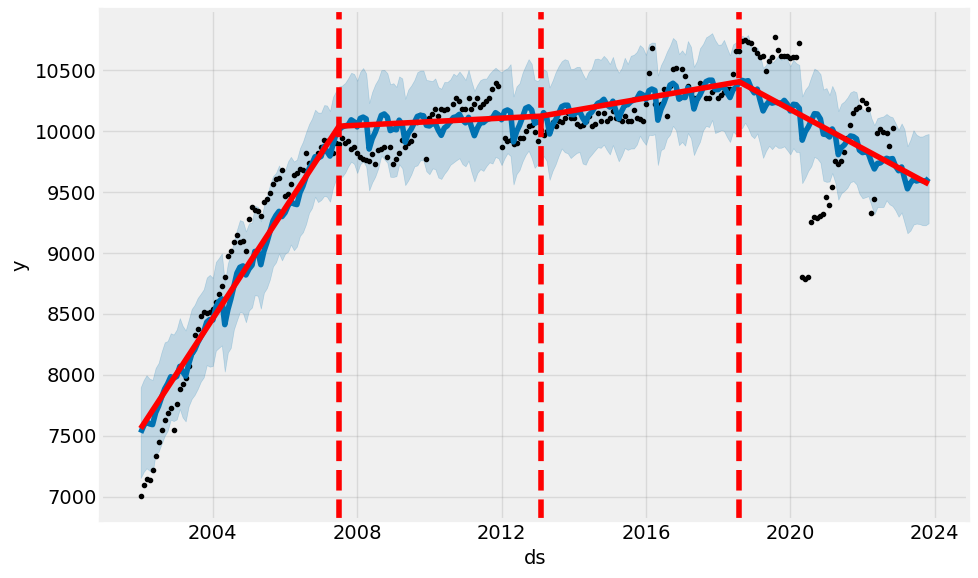

In [29]:
pro_change= Prophet(n_changepoints=3, yearly_seasonality=True)
forecast = pro_change.fit(df).predict(future_dates)
fig= pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

[26/Feb/2023 07:34:16] INFO - Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


[26/Feb/2023 07:34:16] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


07:34:16 - cmdstanpy - INFO - Chain [1] start processing


[26/Feb/2023 07:34:16] INFO - Chain [1] start processing


07:34:16 - cmdstanpy - INFO - Chain [1] done processing


[26/Feb/2023 07:34:16] INFO - Chain [1] done processing


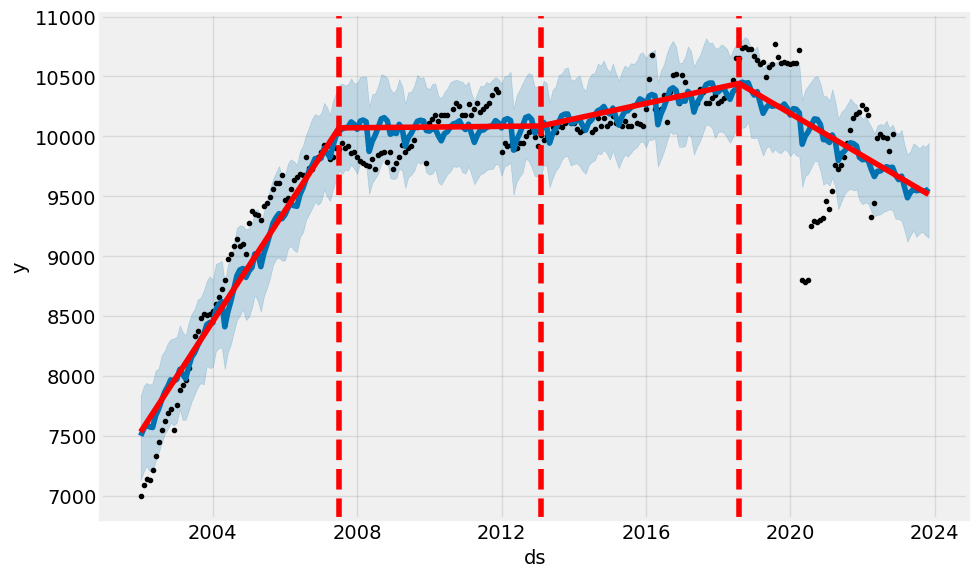

In [30]:
pro_change= Prophet(n_changepoints=3, yearly_seasonality=True, changepoint_prior_scale=0.08)
forecast = pro_change.fit(df).predict(future_dates)
fig= pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

[26/Feb/2023 07:34:16] INFO - Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


[26/Feb/2023 07:34:16] INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


07:34:16 - cmdstanpy - INFO - Chain [1] start processing


[26/Feb/2023 07:34:16] INFO - Chain [1] start processing


07:34:16 - cmdstanpy - INFO - Chain [1] done processing


[26/Feb/2023 07:34:16] INFO - Chain [1] done processing


07:34:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted


[26/Feb/2023 07:34:16] ERROR - Chain [1] error: error during processing Operation not permitted


[26/Feb/2023 07:34:16] WARNING - Optimization terminated abnormally. Falling back to Newton.


07:34:16 - cmdstanpy - INFO - Chain [1] start processing


[26/Feb/2023 07:34:16] INFO - Chain [1] start processing


07:34:17 - cmdstanpy - INFO - Chain [1] done processing


[26/Feb/2023 07:34:17] INFO - Chain [1] done processing


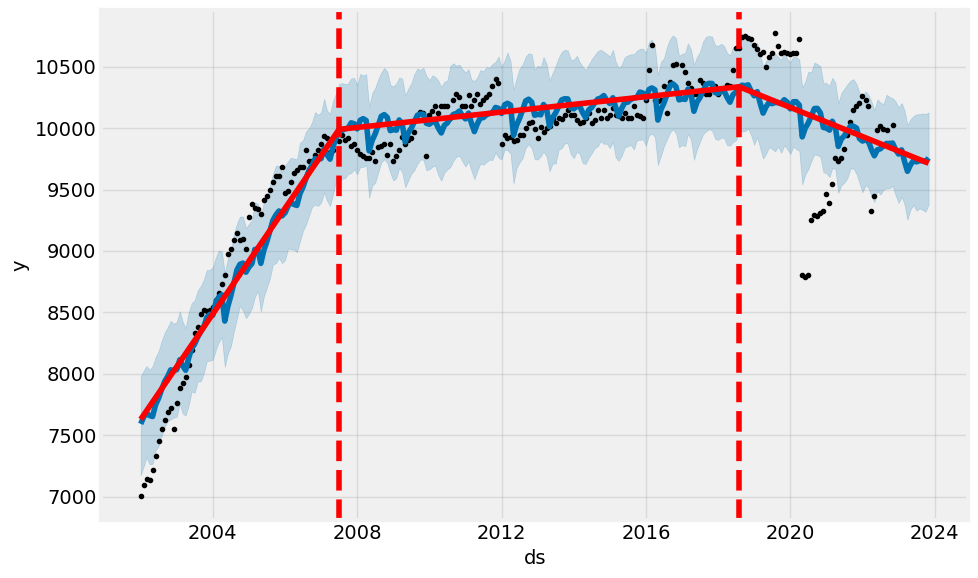

In [31]:
pro_change= Prophet(n_changepoints=3, yearly_seasonality=True, changepoint_prior_scale=0.02)
forecast = pro_change.fit(df).predict(future_dates)
fig= pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

In [32]:
# python program to check if a path exists
#if path doesn’t exist we create a new path
from pathlib import Path

#creating a new directory called pythondirectory
Path(f"{PROJECT_ROOT}\\{model_dir}\\").mkdir(parents=True, exist_ok=True)

In [33]:
# Python
from prophet.serialize import model_to_json, model_from_json

with open(f"{PROJECT_ROOT}\\{model_dir}\\{COUNTRY}.json", 'w') as fout:
    fout.write(model_to_json(model2))  # Save model

# with open('serialized_model.json', 'r') as fin:
#     m = model_from_json(fin.read())  # Load model